In [2]:
!sudo apt install -y libsndfile1
!pip install numba==0.48
!pip install git+https://github.com/fastaudio/fastaudio.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
  Cloning https://github.com/fastaudio/fastaudio.git to /tmp/pip-req-build-uadtincv
  Running command git clone -q https://github.com/fastaudio/fastaudio.git /tmp/pip-req-build-uadtincv
     |████████████████████████████████| 194kB 8.6MB/s 
     |████████████████████████████████| 7.6MB 12.7MB/s 
     |████████████████████████████████| 184kB 53.4MB/s 
     |████████████████████████████████| 788kB 61.0MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 358kB 59.7MB/s 
  Created wheel for fastaudio: filename=fastaudio-0.1.4.post0.dev1+g449a0b4-py2.py3-none-any.whl size=18337 sha256=848ad7b305928beedec6b98779b9ac0d7ffa6bd2c5985d05439d7152ba6de135
  Stored in direct

In [43]:
!git clone https://github.com/nestordemeure/ManifoldMixupV2.git

Cloning into 'ManifoldMixupV2'...
remote: Enumerating objects: 370, done.
remote: Counting objects: 100% (370/370), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 370 (delta 202), reused 347 (delta 181), pack-reused 0
Receiving objects: 100% (370/370), 651.94 KiB | 1.99 MiB/s, done.
Resolving deltas: 100% (202/202), done.


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torchaudio
torchaudio.set_audio_backend("sox_io")
import torchaudio

In [4]:
import numpy as np
import pandas as pd
import os
import sys
sys.path.append("..")

import librosa as lr
import librosa.display

import soundfile as sf
import io

from pathlib import Path
from tqdm.notebook import tqdm

from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastai.torch_basics import *
from fastai.basics import *
from fastai.data.all import *
from fastai.callback.all import *
from fastai.vision.all import *



import fastai
fastai.__version__

'2.1.8'

In [44]:
%run /content/ManifoldMixupV2/manifold_mixup.py

<Figure size 432x288 with 0 Axes>

In [10]:
from manifold_mixup import *
import manifold_mixup as mm
ManifoldMixup()

ManifoldMixup

In [5]:
from google.colab import drive
drive.mount('/content/drive')# You must grant COLAB access to your Google Drive

Mounted at /content/drive


In [6]:
DATA_ROOT = Path("/content/drive/MyDrive/Colab Notebooks/RainForestAudio/data")
AUDIO_ROOT = Path(DATA_ROOT/"train/")
TRAIN_AUDIO_ROOT = Path(DATA_ROOT/"samples_long")
TEST_AUDIO_ROOT = Path(DATA_ROOT/"test")
df_train = pd.DataFrame([path.stem for path in Path(TRAIN_AUDIO_ROOT).glob("*.flac")], columns=["recording_id"])
df_test = pd.DataFrame([path.stem for path in Path(TEST_AUDIO_ROOT).glob("*.flac")], columns=["recording_id"])
df = pd.read_csv(Path(DATA_ROOT/"train_tp.csv"))
print(df_train.shape, df_test.shape)
df

(1216, 1) (1992, 1)


recording_id  species_id  songtype_id  ...     f_min    t_max     f_max
0       003bec244          14            1  ...  2531.250  45.1307   5531.25
1       006ab765f          23            1  ...  7235.160  46.0452  11283.40
2       007f87ba2          12            1  ...   562.500  42.2720   3281.25
3       0099c367b          17            4  ...  1464.260  55.1996   4565.04
4       009b760e6          10            1  ...   947.461  52.5293  10852.70
...           ...         ...          ...  ...       ...      ...       ...
1211    fe8d9ac40          13            1  ...    93.750  54.0960    843.75
1212    fea6b438a           4            1  ...  2531.250  45.7653   4031.25
1213    ff2eb9ce5           0            1  ...  5906.250  16.0213   8250.00
1214    ffb8d8391           5            1  ...  4781.250  16.6987  10406.20
1215    ffb9a7b9a          18            1  ...  3187.500  41.0133   5062.50

[1216 rows x 7 columns]

7.923900000000003

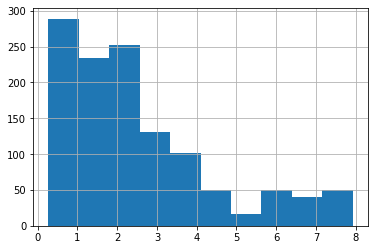

In [7]:
df["dur"] = df["t_max"] - df["t_min"]
df["freq"] = df["f_max"] - df["f_min"]
df["dur"].hist()
df["dur"].max()

In [13]:
df.head(), df.columns

(  recording_id  species_id  songtype_id  ...     f_max     dur      freq
 0    003bec244          14            1  ...   5531.25  0.5867  3000.000
 1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
 2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
 3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
 4    009b760e6          10            1  ...  10852.70  2.4439  9905.239
 
 [5 rows x 9 columns],
 Index(['recording_id', 'species_id', 'songtype_id', 't_min', 'f_min', 't_max',
        'f_max', 'dur', 'freq'],
       dtype='object'))

In [125]:
df[df["species_id"] == 3]

recording_id  species_id  songtype_id  ...   f_max     dur     freq
27      050d0ca85           3            1  ...  2812.5  0.7413  1781.25
38      06c44d203           3            1  ...  2812.5  0.7413  1781.25
65      0eb2079ea           3            1  ...  2812.5  0.7414  1781.25
80      133001416           3            1  ...  2812.5  0.7413  1781.25
93      14f6cbe5c           3            1  ...  2812.5  0.7413  1781.25
105     163e86660           3            1  ...  2812.5  0.7413  1781.25
173     2322ec1d3           3            1  ...  2812.5  0.7414  1781.25
196     288e5d13f           3            1  ...  2812.5  0.7414  1781.25
199     29127020a           3            1  ...  2812.5  0.7413  1781.25
209     2bcddf9a5           3            1  ...  2812.5  0.7413  1781.25
231     2eb098e76           3            1  ...  2812.5  0.7413  1781.25
250     32278292a           3            1  ...  2812.5  0.7413  1781.25
273     368be0579           3            1  ...  2812.5  0.7413  1781.25
349     489ecb611           3            1  ...  2812.5  0.7413  1781.25
390     5280a7fe9           3            1  ...  2812.5  0.7413  1781.25
394     534b6a4a0           3            1  ...  2812.5  0.7413  1781.25
399     541550e6c           3            1  ...  2812.5  0.7413  1781.25
429     581d07559           3            1  ...  2812.5  0.7414  1781.25
433     5877cea08           3            1  ...  2812.5  0.7414  1781.25
454     5b54af5a2           3            1  ...  2812.5  0.7414  1781.25
487     6102fb9d6           3            1  ...  2812.5  0.7413  1781.25
493     61f1c7d5f           3            1  ...  2812.5  0.7413  1781.25
494     621dc03b6           3            1  ...  2812.5  0.7414  1781.25
499     6351581d6           3            1  ...  2812.5  0.7414  1781.25
513     687733bf1           3            1  ...  2812.5  0.7413  1781.25
535     6c4ce1cf2           3            1  ...  2812.5  0.7414  1781.25
540     6d93f853d           3            1  ...  2812.5  0.7413  1781.25
569     73f2ff0fd           3            1  ...  2812.5  0.7413  1781.25
617     7ada8c4da           3            1  ...  2812.5  0.7413  1781.25
640     807efd6bb           3            1  ...  2812.5  0.7413  1781.25
682     8a99905ac           3            1  ...  2812.5  0.7413  1781.25
684     8b237e9eb           3            1  ...  2812.5  0.7413  1781.25
711     929d655d3           3            1  ...  2812.5  0.7413  1781.25
770     a1b1a5e31           3            1  ...  2812.5  0.7413  1781.25
823     ae210f726           3            1  ...  2812.5  0.7414  1781.25
829     aedfcfe60           3            1  ...  2812.5  0.7413  1781.25
831     aefd0f061           3            1  ...  2812.5  0.7414  1781.25
905     be6a8ad0d           3            1  ...  2812.5  0.7414  1781.25
908     bf6aa9579           3            1  ...  2812.5  0.7414  1781.25
918     c12e0a62b           3            1  ...  2812.5  0.7413  1781.25
921     c15840ebf           3            1  ...  2812.5  0.7413  1781.25
936     c5503ce7b           3            1  ...  2812.5  0.7413  1781.25
954     c91cae4aa           3            1  ...  2812.5  0.7413  1781.25
969     cc2c48fd7           3            1  ...  2812.5  0.7413  1781.25
987     cf867adcc           3            1  ...  2812.5  0.7414  1781.25
1033    d7cf29809           3            1  ...  2812.5  0.7413  1781.25
1038    d82a81c98           3            1  ...  2812.5  0.7413  1781.25
1060    db3cdbf35           3            1  ...  2812.5  0.7413  1781.25
1117    e7bc335fa           3            1  ...  2812.5  0.7413  1781.25
1156    ee80e2415           3            1  ...  2812.5  0.7413  1781.25

[50 rows x 9 columns]

In [216]:
from sklearn.model_selection import StratifiedKFold

In [222]:
skf = StratifiedKFold(n_splits=5)
train_index = []
test_index = []
for trn, tst in skf.split(df[['recording_id', 'f_min', 'f_max', 'dur', 'freq']], df['species_id']):
  train_index.append(trn)
  test_index.append(tst)
len(test_index)

5

In [350]:
for n, row in df.iterrows():
  fname = row["recording_id"] + "_" + str(row["species_id"]) + ".flac"
  #print(fname)
  if Path.exists(TRAIN_AUDIO_ROOT/fname):
    print(TRAIN_AUDIO_ROOT/fname)
    #pass
  else:
    print(fname, "not exist")

/content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples/003bec244_14.flac
/content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples/006ab765f_23.flac
/content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples/007f87ba2_12.flac
/content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples/0099c367b_17.flac
/content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples/009b760e6_10.flac
/content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples/00b404881_8.flac
/content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples/00d442df7_0.flac
/content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples/011f25080_18.flac
/content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples/015113cad_15.flac
/content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples/0151b7d20_1.flac
/content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples/01b41f92b_6.flac
/content/drive/MyDrive/Colab Notebooks/RainForestAudio/dat

# Define multi class model

In [15]:
def get_y_fn(x):
  y = str(x).split(".")[0].split('_')[-2]
  return y


cfg = AudioConfig.BasicMelSpectrogram(
        f_min=df["f_min"].min(),
        f_max=df["f_max"].max(),
        n_fft=1024,
        n_mels=384,
        hop_length=400
   )

## Calculate mean and std

In [ ]:
class StatsRecorder:
    def __init__(self, red_dims=(0,2,3)):
        """Accumulates normalization statistics across mini-batches.
        ref: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
        """
        self.red_dims = red_dims # which mini-batch dimensions to average over
        self.nobservations = 0   # running number of observations

    def update(self, data):
        """
        data: ndarray, shape (nobservations, ndimensions)
        """
        # initialize stats and dimensions on first batch
        print(data.shape)
        if self.nobservations == 0:
            self.mean = data.mean(dim=self.red_dims, keepdim=True)
            self.std  = data.std (dim=self.red_dims,keepdim=True)
            self.nobservations = data.shape[0]
            self.ndimensions   = data.shape[1]
        else:
            # if data.shape[1] != self.ndimensions:
            #     raise ValueError('Data dims do not match previous observations.')
            
            # find mean of new mini batch
            newmean = data.mean(dim=self.red_dims, keepdim=True)
            newstd  = data.std(dim=self.red_dims, keepdim=True)
            
            # update number of observations
            m = self.nobservations * 1.0
            n = data.shape[0]

            # update running statistics
            tmp = self.mean
            self.mean = m/(m+n)*tmp + n/(m+n)*newmean
            self.std  = m/(m+n)*self.std**2 + n/(m+n)*newstd**2 +\
                        m*n/(m+n)**2 * (tmp - newmean)**2
            self.std  = torch.sqrt(self.std)
                                 
            # update total number of seen samples
            self.nobservations += n



auds_simple = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 #get_x = ColReader("recording_id", pref=TRAIN_AUDIO_ROOT, suff=".flac"), 
                 get_items=get_audio_files,
                 item_tfms = [Resample(28000),ResizeSignal(8000, pad_mode=AudioPadType.Repeat) ],
                 splitter = RandomSplitter(),
                 #batch_tfms = [a2s],
                 #get_y = ColReader("species_id"), 
                 get_y=get_y_fn,
                 batch_tfms =  [AudioToSpec.from_cfg(cfg),]
                )

print(auds_simple.summary(TRAIN_AUDIO_ROOT))



# create recorders
channel_stats = StatsRecorder(red_dims=(0,1,3))

# step through the training dataset
with torch.no_grad():
    for idx,(x,y) in enumerate(auds_simple.dataloaders(TRAIN_AUDIO_ROOT).train):
        # update normalization statistics
        #global_stats.update(x)
        channel_stats.update(x)
    
# parse out both sets of stats
channel_mean,channel_std = channel_stats.mean,channel_stats.std

ch_mean = channel_mean.cpu().mean(axis=0, keepdim=True).mean(axis=3, keepdim=True)
ch_std = channel_std.cpu().mean(axis=0, keepdim=True).mean(axis=3, keepdim=True)

ChannelSpecNorm = SpecNormalize(ch_mean, ch_std, axes=(0))

/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (384) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


Setting-up type transforms pipelines
Found 1161 items
2 datasets of sizes 929,232
Setting up Pipeline: partial
Setting up Pipeline: get_y_fn -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: partial
    starting from
      /content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples/35f9c5c38_5.flac
    applying partial gives
      AudioTensor of size 1x69632
  Pipeline: get_y_fn -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples/35f9c5c38_5.flac
    applying get_y_fn gives
      5
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(19)

Final sample: (AudioTensor([[ 0.0056,  0.0037,  0.0030,  ...,  0.0025, -0.0008,  0.0018]]), TensorCategory(19))


Found 1161 items
2 datasets of sizes 929,232
Setting up Pipeline: partial
Setting up Pipeline: get_y_fn -> Categorize -- {'vocab': Non

/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)



Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resample -> DownmixMono -> ResizeSignal -> ToTensor
    starting from
      (AudioTensor of size 1x69632, TensorCategory(19))
    applying Resample gives
      (AudioTensor of size 1x121856, TensorCategory(19))
    applying DownmixMono gives
      (AudioTensor of size 1x121856, TensorCategory(19))
    applying ResizeSignal gives
      (AudioTensor of size 1x224000, TensorCategory(19))
    applying ToTensor gives
      (AudioTensor of size 1x224000, TensorCategory(19))

Adding the next 3 samples

No before_batch transform to apply

Collating items in a batch

Applying batch_tfms to the batch built
  Pipeline: AudioToSpec -> IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}
    starting from
      (AudioTensor of size 4x1x224000, TensorCategory([19, 21, 14,  1], device='cuda:0'))
    applying AudioToSpec gives
      (AudioSpectrogram of size 4x1x384x561, TensorCategory([19, 21, 14,  1], device='cuda:0'))
    applying

In [ ]:
np.save("channel_std", ch_std.cpu().numpy(), allow_pickle=True)
np.save("channel_mean", ch_mean.cpu().numpy(), allow_pickle=True)

In [9]:
ch_std = torch.Tensor(np.load(Path(DATA_ROOT/"../channel_std.npy"),  allow_pickle=True))
ch_mean = torch.Tensor(np.load(Path(DATA_ROOT/"../channel_mean.npy"), allow_pickle=True))

## Define db and dls

In [10]:
Resample.split_idx = None #both
ResizeSignal.split_idx = None 
AudioToSpec.split_idx = None
SGRoll.split_idx = 0 #only train
MaskFreq.split_idx = None
MaskTime.split_idx = None
Normalize.split_idx = None


SGRoll.split_idx, Resample.split_idx, MaskFreq.split_idx

(0, None, None)

In [238]:
val_index=[]
for n, i in enumerate(get_audio_files(TRAIN_AUDIO_ROOT)):
  print(i.stem)
  fname = i.stem.split("_")
  for j in range(5):
    print(df.loc[test_index[j].tolist()].head())
    if fname[0] in df.loc[test_index[j].tolist()]["recording_id"].values and fname[1] in df.loc[test_index[j].tolist()]["species_id"].values: 
      df[df["recording_id"] == fname[0] and df["species_id"] == fname[1]]["val_group"] = j 
      df[df["recording_id"] == fname[0] and df["species_id"] == fname[1]]["val_index"] = n 

22b46c334_8
  recording_id  species_id  songtype_id  ...     f_max     dur      freq
0    003bec244          14            1  ...   5531.25  0.5867  3000.000
1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
4    009b760e6          10            1  ...  10852.70  2.4439  9905.239

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
152    1fbc39373          16            4  ...  4593.75  1.8346  1500.00
156    2026bced7          12            1  ...  3281.25  3.1360  2718.75
164    21e2f2977          15            1  ...  1125.00  3.3440  1031.25
170    22da462f9           1            1  ...  5625.00  0.8960  1781.25
179    247d81f2b           1            1  ...  5625.00  0.8960  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

  recording_id  species_id  songtype_id  ...     f_max     dur      freq
0    003bec244          14            1  ...   5531.25  0.5867  3000.000
1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
4    009b760e6          10            1  ...  10852.70  2.4439  9905.239

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
152    1fbc39373          16            4  ...  4593.75  1.8346  1500.00
156    2026bced7          12            1  ...  3281.25  3.1360  2718.75
164    21e2f2977          15            1  ...  1125.00  3.3440  1031.25
170    22da462f9           1            1  ...  5625.00  0.8960  1781.25
179    247d81f2b           1            1  ...  5625.00  0.8960  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

247d81f2b_1
  recording_id  species_id  songtype_id  ...     f_max     dur      freq
0    003bec244          14            1  ...   5531.25  0.5867  3000.000
1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
4    009b760e6          10            1  ...  10852.70  2.4439  9905.239

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
152    1fbc39373          16            4  ...  4593.75  1.8346  1500.00
156    2026bced7          12            1  ...  3281.25  3.1360  2718.75
164    21e2f2977          15            1  ...  1125.00  3.3440  1031.25
170    22da462f9           1            1  ...  5625.00  0.8960  1781.25
179    247d81f2b           1            1  ...  5625.00  0.8960  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

    recording_id  species_id  songtype_id  ...     f_max     dur     freq
840    b01abd3b2           9            1  ...   5718.75  3.5627  4875.00
867    b6b2bb1cd           6            1  ...   4406.25  2.1440  3843.75
869    b7485fa88           6            1  ...   4406.25  2.1440  3843.75
892    bc18e6dba          21            1  ...   4125.00  1.0934   843.75
896    bcd686baf           7            1  ...  11437.50  3.1413  6750.00

[5 rows x 9 columns]
2695a2878_23
  recording_id  species_id  songtype_id  ...     f_max     dur      freq
0    003bec244          14            1  ...   5531.25  0.5867  3000.000
1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
4    009b760e6          10            1  ...  10852.70  2.4439  9905.239

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     d

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso


    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    3ffaeaa6c          15            1  ...  1125.00  3.3440  1031.25
317    41829d963           2            1  ...  3000.00  1.7760  2531.25
329    43d34d63c          15            1  ...  1125.00  3.3440  1031.25
330    43d34d63c           2            1  ...  3000.00  1.7760  2531.25
379    4f600e6f7          11            1  ...  5684.77  1.1378  3875.98

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
606    796ab9da1          15            1  ...   1125.0  3.3440  1031.25
609    79f7b3873          15            1  ...   1125.0  3.3440  1031.25
638    804fa03e1          15            1  ...   1125.0  3.3440  1031.25
669    87e518677           7            1  ...  11437.5  3.1414  6750.00
682    8a99905ac           3            1  ...   2812.5  0.7413  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...     f_max     dur     freq
840  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

295f49a04_10
  recording_id  species_id  songtype_id  ...     f_max     dur      freq
0    003bec244          14            1  ...   5531.25  0.5867  3000.000
1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
4    009b760e6          10            1  ...  10852.70  2.4439  9905.239

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
152    1fbc39373          16            4  ...  4593.75  1.8346  1500.00
156    2026bced7          12            1  ...  3281.25  3.1360  2718.75
164    21e2f2977          15            1  ...  1125.00  3.3440  1031.25
170    22da462f9           1            1  ...  5625.00  0.8960  1781.25
179    247d81f2b           1            1  ...  5625.00  0.8960  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

2bf32cf03_8
  recording_id  species_id  songtype_id  ...     f_max     dur      freq
0    003bec244          14            1  ...   5531.25  0.5867  3000.000
1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
4    009b760e6          10            1  ...  10852.70  2.4439  9905.239

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
152    1fbc39373          16            4  ...  4593.75  1.8346  1500.00
156    2026bced7          12            1  ...  3281.25  3.1360  2718.75
164    21e2f2977          15            1  ...  1125.00  3.3440  1031.25
170    22da462f9           1            1  ...  5625.00  0.8960  1781.25
179    247d81f2b           1            1  ...  5625.00  0.8960  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

    recording_id  species_id  songtype_id  ...     f_max     dur     freq
840    b01abd3b2           9            1  ...   5718.75  3.5627  4875.00
867    b6b2bb1cd           6            1  ...   4406.25  2.1440  3843.75
869    b7485fa88           6            1  ...   4406.25  2.1440  3843.75
892    bc18e6dba          21            1  ...   4125.00  1.0934   843.75
896    bcd686baf           7            1  ...  11437.50  3.1413  6750.00

[5 rows x 9 columns]
2cf89ef6b_1
  recording_id  species_id  songtype_id  ...     f_max     dur      freq
0    003bec244          14            1  ...   5531.25  0.5867  3000.000
1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
4    009b760e6          10            1  ...  10852.70  2.4439  9905.239

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     du

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    3ffaeaa6c          15            1  ...  1125.00  3.3440  1031.25
317    41829d963           2            1  ...  3000.00  1.7760  2531.25
329    43d34d63c          15            1  ...  1125.00  3.3440  1031.25
330    43d34d63c           2            1  ...  3000.00  1.7760  2531.25
379    4f600e6f7          11            1  ...  5684.77  1.1378  3875.98

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
606    796ab9da1          15            1  ...   1125.0  3.3440  1031.25
609    79f7b3873          15            1  ...   1125.0  3.3440  1031.25
638    804fa03e1          15            1  ...   1125.0  3.3440  1031.25
669    87e518677           7            1  ...  11437.5  3.1414  6750.00
682    8a99905ac           3            1  ...   2812.5  0.7413  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...     f_max     dur     freq
840   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    3ffaeaa6c          15            1  ...  1125.00  3.3440  1031.25
317    41829d963           2            1  ...  3000.00  1.7760  2531.25
329    43d34d63c          15            1  ...  1125.00  3.3440  1031.25
330    43d34d63c           2            1  ...  3000.00  1.7760  2531.25
379    4f600e6f7          11            1  ...  5684.77  1.1378  3875.98

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
606    796ab9da1          15            1  ...   1125.0  3.3440  1031.25
609    79f7b3873          15            1  ...   1125.0  3.3440  1031.25
638    804fa03e1          15            1  ...   1125.0  3.3440  1031.25
669    87e518677           7            1  ...  11437.5  3.1414  6750.00
682    8a99905ac           3            1  ...   2812.5  0.7413  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...     f_max     dur     freq
840   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

  recording_id  species_id  songtype_id  ...     f_max     dur      freq
0    003bec244          14            1  ...   5531.25  0.5867  3000.000
1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
4    009b760e6          10            1  ...  10852.70  2.4439  9905.239

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
152    1fbc39373          16            4  ...  4593.75  1.8346  1500.00
156    2026bced7          12            1  ...  3281.25  3.1360  2718.75
164    21e2f2977          15            1  ...  1125.00  3.3440  1031.25
170    22da462f9           1            1  ...  5625.00  0.8960  1781.25
179    247d81f2b           1            1  ...  5625.00  0.8960  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    3ffaeaa6c          15            1  ...  1125.00  3.3440  1031.25
317    41829d963           2            1  ...  3000.00  1.7760  2531.25
329    43d34d63c          15            1  ...  1125.00  3.3440  1031.25
330    43d34d63c           2            1  ...  3000.00  1.7760  2531.25
379    4f600e6f7          11            1  ...  5684.77  1.1378  3875.98

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
606    796ab9da1          15            1  ...   1125.0  3.3440  1031.25
609    79f7b3873          15            1  ...   1125.0  3.3440  1031.25
638    804fa03e1          15            1  ...   1125.0  3.3440  1031.25
669    87e518677           7            1  ...  11437.5  3.1414  6750.00
682    8a99905ac           3            1  ...   2812.5  0.7413  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...     f_max     dur     freq
840   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

    recording_id  species_id  songtype_id  ...     f_max     dur     freq
840    b01abd3b2           9            1  ...   5718.75  3.5627  4875.00
867    b6b2bb1cd           6            1  ...   4406.25  2.1440  3843.75
869    b7485fa88           6            1  ...   4406.25  2.1440  3843.75
892    bc18e6dba          21            1  ...   4125.00  1.0934   843.75
896    bcd686baf           7            1  ...  11437.50  3.1413  6750.00

[5 rows x 9 columns]
3647cd276_15
  recording_id  species_id  songtype_id  ...     f_max     dur      freq
0    003bec244          14            1  ...   5531.25  0.5867  3000.000
1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
4    009b760e6          10            1  ...  10852.70  2.4439  9905.239

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     d

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    3ffaeaa6c          15            1  ...  1125.00  3.3440  1031.25
317    41829d963           2            1  ...  3000.00  1.7760  2531.25
329    43d34d63c          15            1  ...  1125.00  3.3440  1031.25
330    43d34d63c           2            1  ...  3000.00  1.7760  2531.25
379    4f600e6f7          11            1  ...  5684.77  1.1378  3875.98

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
606    796ab9da1          15            1  ...   1125.0  3.3440  1031.25
609    79f7b3873          15            1  ...   1125.0  3.3440  1031.25
638    804fa03e1          15            1  ...   1125.0  3.3440  1031.25
669    87e518677           7            1  ...  11437.5  3.1414  6750.00
682    8a99905ac           3            1  ...   2812.5  0.7413  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...     f_max     dur     freq
840   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    3ffaeaa6c          15            1  ...  1125.00  3.3440  1031.25
317    41829d963           2            1  ...  3000.00  1.7760  2531.25
329    43d34d63c          15            1  ...  1125.00  3.3440  1031.25
330    43d34d63c           2            1  ...  3000.00  1.7760  2531.25
379    4f600e6f7          11            1  ...  5684.77  1.1378  3875.98

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
606    796ab9da1          15            1  ...   1125.0  3.3440  1031.25
609    79f7b3873          15            1  ...   1125.0  3.3440  1031.25
638    804fa03e1          15            1  ...   1125.0  3.3440  1031.25
669    87e518677           7            1  ...  11437.5  3.1414  6750.00
682    8a99905ac           3            1  ...   2812.5  0.7413  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...     f_max     dur     freq
840   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

  recording_id  species_id  songtype_id  ...     f_max     dur      freq
0    003bec244          14            1  ...   5531.25  0.5867  3000.000
1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
4    009b760e6          10            1  ...  10852.70  2.4439  9905.239

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
152    1fbc39373          16            4  ...  4593.75  1.8346  1500.00
156    2026bced7          12            1  ...  3281.25  3.1360  2718.75
164    21e2f2977          15            1  ...  1125.00  3.3440  1031.25
170    22da462f9           1            1  ...  5625.00  0.8960  1781.25
179    247d81f2b           1            1  ...  5625.00  0.8960  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    3ffaeaa6c          15            1  ...  1125.00  3.3440  1031.25
317    41829d963           2            1  ...  3000.00  1.7760  2531.25
329    43d34d63c          15            1  ...  1125.00  3.3440  1031.25
330    43d34d63c           2            1  ...  3000.00  1.7760  2531.25
379    4f600e6f7          11            1  ...  5684.77  1.1378  3875.98

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
606    796ab9da1          15            1  ...   1125.0  3.3440  1031.25
609    79f7b3873          15            1  ...   1125.0  3.3440  1031.25
638    804fa03e1          15            1  ...   1125.0  3.3440  1031.25
669    87e518677           7            1  ...  11437.5  3.1414  6750.00
682    8a99905ac           3            1  ...   2812.5  0.7413  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...     f_max     dur     freq
840   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

    recording_id  species_id  songtype_id  ...    f_max     dur     freq
152    1fbc39373          16            4  ...  4593.75  1.8346  1500.00
156    2026bced7          12            1  ...  3281.25  3.1360  2718.75
164    21e2f2977          15            1  ...  1125.00  3.3440  1031.25
170    22da462f9           1            1  ...  5625.00  0.8960  1781.25
179    247d81f2b           1            1  ...  5625.00  0.8960  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    3ffaeaa6c          15            1  ...  1125.00  3.3440  1031.25
317    41829d963           2            1  ...  3000.00  1.7760  2531.25
329    43d34d63c          15            1  ...  1125.00  3.3440  1031.25
330    43d34d63c           2            1  ...  3000.00  1.7760  2531.25
379    4f600e6f7          11            1  ...  5684.77  1.1378  3875.98

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
606    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

    recording_id  species_id  songtype_id  ...    f_max     dur     freq
152    1fbc39373          16            4  ...  4593.75  1.8346  1500.00
156    2026bced7          12            1  ...  3281.25  3.1360  2718.75
164    21e2f2977          15            1  ...  1125.00  3.3440  1031.25
170    22da462f9           1            1  ...  5625.00  0.8960  1781.25
179    247d81f2b           1            1  ...  5625.00  0.8960  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    3ffaeaa6c          15            1  ...  1125.00  3.3440  1031.25
317    41829d963           2            1  ...  3000.00  1.7760  2531.25
329    43d34d63c          15            1  ...  1125.00  3.3440  1031.25
330    43d34d63c           2            1  ...  3000.00  1.7760  2531.25
379    4f600e6f7          11            1  ...  5684.77  1.1378  3875.98

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
606    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

  recording_id  species_id  songtype_id  ...     f_max     dur      freq
0    003bec244          14            1  ...   5531.25  0.5867  3000.000
1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
4    009b760e6          10            1  ...  10852.70  2.4439  9905.239

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
152    1fbc39373          16            4  ...  4593.75  1.8346  1500.00
156    2026bced7          12            1  ...  3281.25  3.1360  2718.75
164    21e2f2977          15            1  ...  1125.00  3.3440  1031.25
170    22da462f9           1            1  ...  5625.00  0.8960  1781.25
179    247d81f2b           1            1  ...  5625.00  0.8960  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

    recording_id  species_id  songtype_id  ...     f_max     dur     freq
840    b01abd3b2           9            1  ...   5718.75  3.5627  4875.00
867    b6b2bb1cd           6            1  ...   4406.25  2.1440  3843.75
869    b7485fa88           6            1  ...   4406.25  2.1440  3843.75
892    bc18e6dba          21            1  ...   4125.00  1.0934   843.75
896    bcd686baf           7            1  ...  11437.50  3.1413  6750.00

[5 rows x 9 columns]
4bb31c8c1_6
  recording_id  species_id  songtype_id  ...     f_max     dur      freq
0    003bec244          14            1  ...   5531.25  0.5867  3000.000
1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
4    009b760e6          10            1  ...  10852.70  2.4439  9905.239

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     du

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

  recording_id  species_id  songtype_id  ...     f_max     dur      freq
0    003bec244          14            1  ...   5531.25  0.5867  3000.000
1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
4    009b760e6          10            1  ...  10852.70  2.4439  9905.239

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
152    1fbc39373          16            4  ...  4593.75  1.8346  1500.00
156    2026bced7          12            1  ...  3281.25  3.1360  2718.75
164    21e2f2977          15            1  ...  1125.00  3.3440  1031.25
170    22da462f9           1            1  ...  5625.00  0.8960  1781.25
179    247d81f2b           1            1  ...  5625.00  0.8960  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

  recording_id  species_id  songtype_id  ...     f_max     dur      freq
0    003bec244          14            1  ...   5531.25  0.5867  3000.000
1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
4    009b760e6          10            1  ...  10852.70  2.4439  9905.239

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
152    1fbc39373          16            4  ...  4593.75  1.8346  1500.00
156    2026bced7          12            1  ...  3281.25  3.1360  2718.75
164    21e2f2977          15            1  ...  1125.00  3.3440  1031.25
170    22da462f9           1            1  ...  5625.00  0.8960  1781.25
179    247d81f2b           1            1  ...  5625.00  0.8960  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    3ffaeaa6c          15            1  ...  1125.00  3.3440  1031.25
317    41829d963           2            1  ...  3000.00  1.7760  2531.25
329    43d34d63c          15            1  ...  1125.00  3.3440  1031.25
330    43d34d63c           2            1  ...  3000.00  1.7760  2531.25
379    4f600e6f7          11            1  ...  5684.77  1.1378  3875.98

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
606    796ab9da1          15            1  ...   1125.0  3.3440  1031.25
609    79f7b3873          15            1  ...   1125.0  3.3440  1031.25
638    804fa03e1          15            1  ...   1125.0  3.3440  1031.25
669    87e518677           7            1  ...  11437.5  3.1414  6750.00
682    8a99905ac           3            1  ...   2812.5  0.7413  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...     f_max     dur     freq
840   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

    recording_id  species_id  songtype_id  ...     f_max     dur     freq
840    b01abd3b2           9            1  ...   5718.75  3.5627  4875.00
867    b6b2bb1cd           6            1  ...   4406.25  2.1440  3843.75
869    b7485fa88           6            1  ...   4406.25  2.1440  3843.75
892    bc18e6dba          21            1  ...   4125.00  1.0934   843.75
896    bcd686baf           7            1  ...  11437.50  3.1413  6750.00

[5 rows x 9 columns]
55648ef63_14
  recording_id  species_id  songtype_id  ...     f_max     dur      freq
0    003bec244          14            1  ...   5531.25  0.5867  3000.000
1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
4    009b760e6          10            1  ...  10852.70  2.4439  9905.239

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     d

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

    recording_id  species_id  songtype_id  ...     f_max     dur     freq
840    b01abd3b2           9            1  ...   5718.75  3.5627  4875.00
867    b6b2bb1cd           6            1  ...   4406.25  2.1440  3843.75
869    b7485fa88           6            1  ...   4406.25  2.1440  3843.75
892    bc18e6dba          21            1  ...   4125.00  1.0934   843.75
896    bcd686baf           7            1  ...  11437.50  3.1413  6750.00

[5 rows x 9 columns]
561ed4362_7
  recording_id  species_id  songtype_id  ...     f_max     dur      freq
0    003bec244          14            1  ...   5531.25  0.5867  3000.000
1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
4    009b760e6          10            1  ...  10852.70  2.4439  9905.239

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     du

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso


579db058c_0
  recording_id  species_id  songtype_id  ...     f_max     dur      freq
0    003bec244          14            1  ...   5531.25  0.5867  3000.000
1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
4    009b760e6          10            1  ...  10852.70  2.4439  9905.239

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
152    1fbc39373          16            4  ...  4593.75  1.8346  1500.00
156    2026bced7          12            1  ...  3281.25  3.1360  2718.75
164    21e2f2977          15            1  ...  1125.00  3.3440  1031.25
170    22da462f9           1            1  ...  5625.00  0.8960  1781.25
179    247d81f2b           1            1  ...  5625.00  0.8960  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

    recording_id  species_id  songtype_id  ...    f_max     dur     freq
152    1fbc39373          16            4  ...  4593.75  1.8346  1500.00
156    2026bced7          12            1  ...  3281.25  3.1360  2718.75
164    21e2f2977          15            1  ...  1125.00  3.3440  1031.25
170    22da462f9           1            1  ...  5625.00  0.8960  1781.25
179    247d81f2b           1            1  ...  5625.00  0.8960  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    3ffaeaa6c          15            1  ...  1125.00  3.3440  1031.25
317    41829d963           2            1  ...  3000.00  1.7760  2531.25
329    43d34d63c          15            1  ...  1125.00  3.3440  1031.25
330    43d34d63c           2            1  ...  3000.00  1.7760  2531.25
379    4f600e6f7          11            1  ...  5684.77  1.1378  3875.98

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
606    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

    recording_id  species_id  songtype_id  ...    f_max     dur     freq
152    1fbc39373          16            4  ...  4593.75  1.8346  1500.00
156    2026bced7          12            1  ...  3281.25  3.1360  2718.75
164    21e2f2977          15            1  ...  1125.00  3.3440  1031.25
170    22da462f9           1            1  ...  5625.00  0.8960  1781.25
179    247d81f2b           1            1  ...  5625.00  0.8960  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    3ffaeaa6c          15            1  ...  1125.00  3.3440  1031.25
317    41829d963           2            1  ...  3000.00  1.7760  2531.25
329    43d34d63c          15            1  ...  1125.00  3.3440  1031.25
330    43d34d63c           2            1  ...  3000.00  1.7760  2531.25
379    4f600e6f7          11            1  ...  5684.77  1.1378  3875.98

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
606    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

  recording_id  species_id  songtype_id  ...     f_max     dur      freq
0    003bec244          14            1  ...   5531.25  0.5867  3000.000
1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
4    009b760e6          10            1  ...  10852.70  2.4439  9905.239

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
152    1fbc39373          16            4  ...  4593.75  1.8346  1500.00
156    2026bced7          12            1  ...  3281.25  3.1360  2718.75
164    21e2f2977          15            1  ...  1125.00  3.3440  1031.25
170    22da462f9           1            1  ...  5625.00  0.8960  1781.25
179    247d81f2b           1            1  ...  5625.00  0.8960  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    3ffaeaa6c          15            1  ...  1125.00  3.3440  1031.25
317    41829d963           2            1  ...  3000.00  1.7760  2531.25
329    43d34d63c          15            1  ...  1125.00  3.3440  1031.25
330    43d34d63c           2            1  ...  3000.00  1.7760  2531.25
379    4f600e6f7          11            1  ...  5684.77  1.1378  3875.98

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
606    796ab9da1          15            1  ...   1125.0  3.3440  1031.25
609    79f7b3873          15            1  ...   1125.0  3.3440  1031.25
638    804fa03e1          15            1  ...   1125.0  3.3440  1031.25
669    87e518677           7            1  ...  11437.5  3.1414  6750.00
682    8a99905ac           3            1  ...   2812.5  0.7413  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...     f_max     dur     freq
840   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

  recording_id  species_id  songtype_id  ...     f_max     dur      freq
0    003bec244          14            1  ...   5531.25  0.5867  3000.000
1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
4    009b760e6          10            1  ...  10852.70  2.4439  9905.239

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
152    1fbc39373          16            4  ...  4593.75  1.8346  1500.00
156    2026bced7          12            1  ...  3281.25  3.1360  2718.75
164    21e2f2977          15            1  ...  1125.00  3.3440  1031.25
170    22da462f9           1            1  ...  5625.00  0.8960  1781.25
179    247d81f2b           1            1  ...  5625.00  0.8960  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

    recording_id  species_id  songtype_id  ...    f_max     dur     freq
308    3ffaeaa6c          15            1  ...  1125.00  3.3440  1031.25
317    41829d963           2            1  ...  3000.00  1.7760  2531.25
329    43d34d63c          15            1  ...  1125.00  3.3440  1031.25
330    43d34d63c           2            1  ...  3000.00  1.7760  2531.25
379    4f600e6f7          11            1  ...  5684.77  1.1378  3875.98

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...    f_max     dur     freq
606    796ab9da1          15            1  ...   1125.0  3.3440  1031.25
609    79f7b3873          15            1  ...   1125.0  3.3440  1031.25
638    804fa03e1          15            1  ...   1125.0  3.3440  1031.25
669    87e518677           7            1  ...  11437.5  3.1414  6750.00
682    8a99905ac           3            1  ...   2812.5  0.7413  1781.25

[5 rows x 9 columns]
    recording_id  species_id  songtype_id  ...     f_max     dur     freq
840   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

KeyboardInterrupt: ignored

In [237]:
df.head()

recording_id  species_id  songtype_id  ...     f_max     dur      freq
0    003bec244          14            1  ...   5531.25  0.5867  3000.000
1    006ab765f          23            1  ...  11283.40  6.0837  4048.240
2    007f87ba2          12            1  ...   3281.25  3.1360  2718.750
3    0099c367b          17            4  ...   4565.04  3.7790  3100.780
4    009b760e6          10            1  ...  10852.70  2.4439  9905.239

[5 rows x 9 columns]

In [97]:
item_tfms = [Resample(28000),ResizeSignal(9000, pad_mode=AudioPadType.Repeat), 
          # AddNoise(noise_level=0.1),
           #  AudioNormalize
           ]
batch_tfms = [ AudioToSpec.from_cfg(cfg), 
  
              SGRoll(), MaskFreq(), MaskTime(), 
              Normalize(ch_mean, ch_std, axes=(0, 1, 3)),
              ]

auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 #get_x = ColReader("recording_id", pref=TRAIN_AUDIO_ROOT, suff=".flac"), 
                 get_items=get_audio_files,
                 item_tfms = item_tfms,
                 #batch_tfms = [a2s],
                 #get_y = ColReader("species_id"), 
                 splitter = RandomSplitter(),
                 get_y=get_y_fn,
                 batch_tfms = batch_tfms
                                  )
print(auds.summary(TRAIN_AUDIO_ROOT))
dls = auds.dataloaders(TRAIN_AUDIO_ROOT, bs=32, verbose=True, before_batch = batch_tfms, 
                       num_workers=4,
                       #, shuffle=True
                      )
#dls.show_batch()


Setting-up type transforms pipelines
Found 1216 items
2 datasets of sizes 973,243
Setting up Pipeline: partial
Setting up Pipeline: get_y_fn -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: partial
    starting from
      /content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples_long/774912d66_23_588.flac
    applying partial gives
      AudioTensor of size 1x277867
  Pipeline: get_y_fn -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples_long/774912d66_23_588.flac
    applying get_y_fn gives
      23
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(16)

Final sample: (AudioTensor([[ 1.5653e-03,  1.9172e-03,  4.1860e-03,  ...,  1.0854e-03,
         -3.1388e-04,  3.5524e-05]]), TensorCategory(16))


Found 1216 items
2 datasets of sizes 973,243
Setting up Pipeline: partial
Setti

In [17]:
def _one_sample_positive_class_precisions(scores, truth):
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)

    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)

    retrieved_classes = np.argsort(scores)[::-1]

    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)

    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True

    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)

    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits

def lwlrap(scores, truth):
    #print(truth.shape, scores.shape)
    num_samples, num_classes = scores.shape
    scores = scores.cpu().numpy()
    gt = np.zeros((num_samples, num_classes))
    for n, i in enumerate(truth.cpu().numpy().astype(int)):
      gt[n, i] = 1
    assert gt.shape == scores.shape
    
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = _one_sample_positive_class_precisions(scores[sample_num, :], gt[sample_num, :])
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = precision_at_hits

    labels_per_class = np.sum(gt > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))

    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    #return per_class_lwlrap, weight_per_class
    return (per_class_lwlrap * weight_per_class).sum()


In [175]:
learn = cnn_learner(dls, 
            resnet50,
            n_in=1, #<- Only audio specific modification here
            #loss_func=BCELossFlat(),
            #cbs=ManifoldMixup(alpha=0.4),
            cbs = OutputMixup(alpha=0.4),
            metrics=[accuracy, lwlrap], wd=1e-3)
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

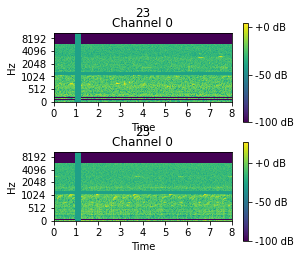

In [14]:
dls.show_batch()

In [ ]:
learn.lr_find()

In [176]:
#learn.load("rn34_3")
learn.fine_tune(60, 1e-3, cbs=SaveModelCallback(monitor="lwlrap")) # for mixup
#learn.fine_tune(30, 1e-3, cbs=SaveModelCallback(monitor="lwlrap", )) # within mixup

Output mixup: the loss function is now properly wrapped.


RuntimeError: ignored

In [141]:
learn.save("rn50_1501_5")

Path('models/rn50_1501_5.pth')

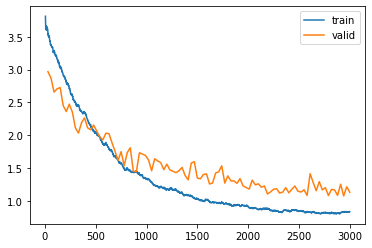

In [102]:
learn.recorder.plot_loss()

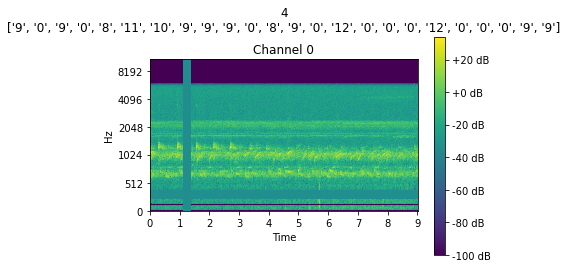

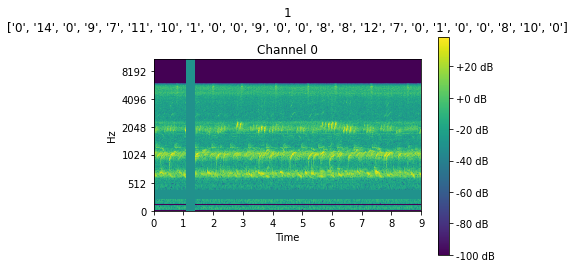

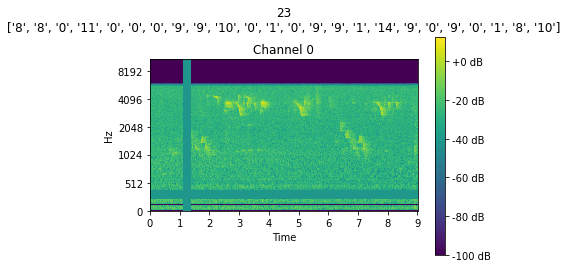

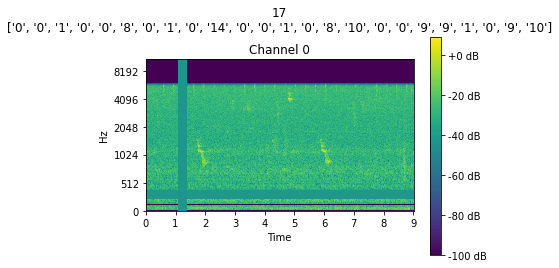

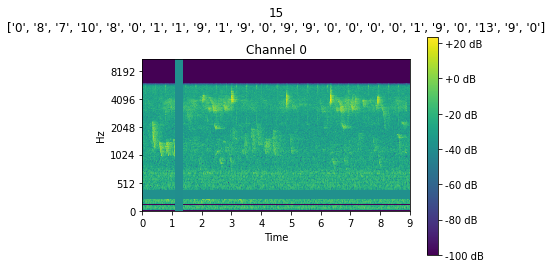

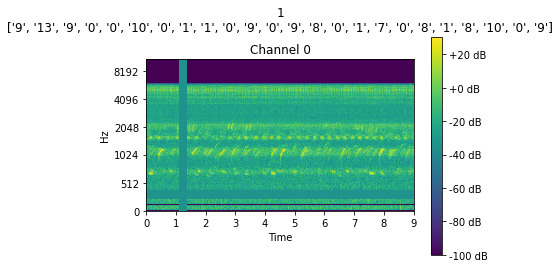

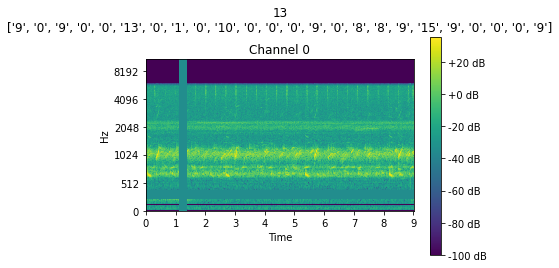

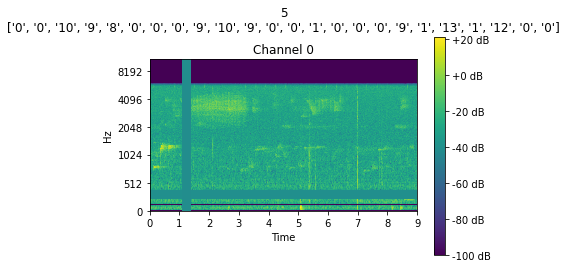

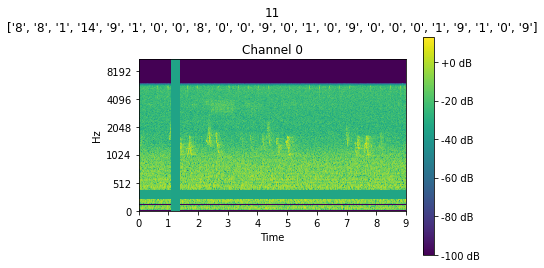

In [103]:
learn.show_results()

## save load models

In [ ]:
#learn.save("rn101_28_1")

Path('models/rn101_28_1.pth')

In [ ]:
#!cp models/* drive/MyDrive/
!cp drive/MyDrive/rn50_26_2.pth models

In [321]:
learn.load("rn50_1401")


## confusion matrix

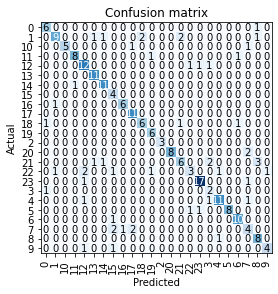

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

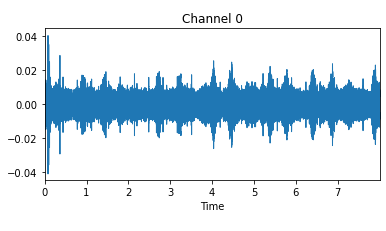

In [118]:
SR = 28000
speakers = get_audio_files(TEST_SAMPLES_AUDIO_ROOT)
speakers[1]
audio = AudioTensor.create(Path("/content/samples/000316da7_8.flac"))
audio.show()

In [ ]:
y, sr = torchaudio.load(speakers[1])
print("Sample rate  :", sr)
print("Signal Length:", len(y))
print("Duration     :", len(y)/sr, "seconds")

Sample rate  : 28000
Signal Length: 1
Duration     : 3.571428571428572e-05 seconds


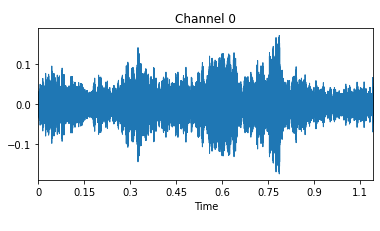

In [ ]:
audio = AudioTensor.create(speakers[2])
tfm = RemoveSilence(remove_type=RemoveType.Trim, threshold=20, pad_ms=50) # кажется в этой задаче бесполезно
tfm(audio).show()
#AudioTensor.create(tfm(y), sr).show()

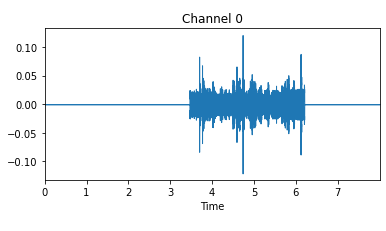

In [129]:
audio = AudioTensor.create("/content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples/06c44d203_3.flac")
tfm = ResizeSignal(8000, pad_mode=AudioPadType.Zeros)
tfm(audio).show()



In [ ]:
audio = AudioTensor.create(speakers[1])
tfm = ResizeSignal(duration=10000) #duration im mlsec
tfm(audio).show()

In [ ]:
y_new, sr_new = librosa.load(speakers[2], sr=16000) #use this
Audio(y_new, rate=sr_new)

In [ ]:
audio = AudioTensor.create(speakers[1])
tfm = Resample(28000) #duration im mlsec
audio2 = tfm(audio)
tmf2 = AudioToSpec.from_cfg(cfg)
audio3 = tmf2(audio2)
audio3.show() 
tmf3 = CropTime(446)
audio4 = tmf3(audio3)
audio4.show() 

NameError: ignored

In [ ]:
audio.shape, audio2.shape, audio3.shape, audio4.shape

(torch.Size([1, 1680000]),
 torch.Size([1, 1680000]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]))

# Prepare test data

In [69]:
#!cp /content/drive/MyDrive/Colab\ Notebooks/RainForestAudio/data/samples.tar.gz .
!tar -xkf samples.tar.gz

In [142]:
learn.load("model")

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:55: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


# Predict all classes

In [147]:
learn.remove_cbs(OutputMixup)
learn.cbs

(#3) [TrainEvalCallback,Recorder,ProgressCallback]

In [162]:
TEST_SAMPLES_AUDIO_ROOT = Path("/content/samples")
print(learn.dls.valid)

test_ds = auds.new(TEST_SAMPLES_AUDIO_ROOT)
test_dl = learn.dls.test_dl(get_audio_files(TEST_SAMPLES_AUDIO_ROOT))
#print(test_dl.summary(TEST_TARGET_AUDIO_ROOT))
test_probas, *_ = learn.tta(dl=test_dl, n=2, use_max=True)

In [163]:
test_probas[0]

tensor([0.0022, 0.0039, 0.0072, 0.1091, 0.1778, 0.0007, 0.0029, 0.0509, 0.4119,
        0.0338, 0.0013, 0.0070, 0.0855, 0.0325, 0.0374, 0.0057, 0.0040, 0.0565,
        0.0103, 0.0116, 0.0080, 0.3750, 0.0123, 0.0014])

In [161]:
learn.predict(Path("/content/samples/000316da7_10.flac"))

('3',
 tensor(17),
 tensor([0.0080, 0.1399, 0.0088, 0.0023, 0.1876, 0.0012, 0.2004, 0.0025, 0.0298,
         0.0083, 0.0029, 0.0040, 0.0380, 0.0064, 0.0042, 0.0015, 0.0290, 0.2676,
         0.0073, 0.0107, 0.0177, 0.0017, 0.0124, 0.0078]))

In [76]:
dls.vocab

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '3', '4', '5', '6', '7', '8', '9']

In [349]:
test_dl.items[0]

AttributeError: ignored

In [164]:
result=[]
for probas, fname in zip(test_probas, test_dl.items):
  print(fname)
  result.append([fname.stem.split("_")[0], fname.stem.split("_")[1], probas.numpy()])
res = pd.DataFrame(result, columns =["recording_id", "part_id", "probas"])
res["part_id"] = res["part_id"].astype(int)
res.to_csv("all_class_pred_2.csv", columns =["recording_id", "part_id", "probas"])

# for n, row in res.sort_values(by = "part_id").groupby(by="recording_id"):
#   print(n, np.stack(row["probas"].to_numpy()))

Выходные данные были обрезаны до нескольких последних строк (5000).
/content/samples/f9bade97d_4.flac
/content/samples/a3ad6ae80_14.flac
/content/samples/398230aad_8.flac
/content/samples/ff0b6944e_0.flac
/content/samples/d00545df6_9.flac
/content/samples/ed75d36e1_12.flac
/content/samples/b90a0b10e_5.flac
/content/samples/51cd29975_0.flac
/content/samples/bb1036ead_8.flac
/content/samples/c244af819_11.flac
/content/samples/547d74e15_11.flac
/content/samples/6c9a8a0d2_4.flac
/content/samples/ed4aed156_14.flac
/content/samples/27224a0ea_2.flac
/content/samples/2889d6cfe_6.flac
/content/samples/47b44e368_9.flac
/content/samples/c0b2be5e2_11.flac
/content/samples/d8166f299_9.flac
/content/samples/6525d9e01_11.flac
/content/samples/164419792_0.flac
/content/samples/a43e226d1_9.flac
/content/samples/040d4f0d5_14.flac
/content/samples/2420703df_14.flac
/content/samples/21eb2ed38_9.flac
/content/samples/7af110303_5.flac
/content/samples/39d659bfb_9.flac
/content/samples/661acb581_5.flac
/cont

In [165]:
subm = []
for n, row in res.groupby(by="recording_id"):
  a = np.stack(row["probas"].values)
  pred = np.concatenate([np.array(n).reshape(1), 
                         #np.where(a>0.7, a, 0).sum(axis=0)
                         a.max(axis=0)
                         ])
  subm.append(pred)
  #print(n)
  if n == "047a7c4bf":
    #print(row["probas"].max(axis=1))
    cls = np.stack(row["probas"].values).max(axis=0).argsort()
    #print(np.stack(row["probas"].values).argsort())
    #print(dls.vocab[cls[-1]], dls.vocab[cls[-2]], dls.vocab[cls[-3]])
#print(subm)
submission = pd.DataFrame(subm, columns=["recording_id"] + ["s" + i for i in dls.vocab])
submission.head(10)

recording_id            s0  ...            s8           s9
0    000316da7    0.11614799  ...    0.02356236   0.22632022
1    003bc2cb2    0.02711941  ...  0.0072316634   0.03161279
2    0061c037e    0.12668172  ...    0.00632061  0.043430142
3    010eb14d3     0.9716186  ...     0.9644119  0.003874375
4    011318064    0.12680036  ...     0.2654976  0.046969924
5    01307e693    0.03161265  ...   0.039366588   0.12137133
6    013bd8b85   0.020852122  ...   0.017634552    0.0188269
7    01812f522   0.020382099  ...   0.017660255   0.07905283
8    019db5220  0.0036784885  ...  0.0028565314  0.004454266
9    01bd97dd6   0.109941825  ...  0.0054805586  0.010726407

[10 rows x 25 columns]

In [166]:
submission.to_csv("subm_5.csv", columns=["recording_id"] + ["s" + str(i) for i in range(24)], index=False)

In [400]:
fsubm = pd.concat([pd.read_csv("subm_0.csv"), pd.read_csv("subm_1.csv"), pd.read_csv("subm_2.csv")])
fs = fsubm.groupby("recording_id").max() - fsubm.groupby("recording_id").mean()
fs

s0        s1        s2  ...       s21       s22       s23
recording_id                                ...                              
000316da7     0.000008  0.000172  0.000525  ...  0.018834  0.002331  0.166573
003bc2cb2     0.000021  0.001138  0.000754  ...  0.000923  0.000740  0.014533
0061c037e     0.000009  0.003840  0.000325  ...  0.007876  0.290014  0.321930
010eb14d3     0.013449  0.112165  0.008705  ...  0.106518  0.023450  0.096730
011318064     0.000114  0.048304  0.000469  ...  0.008586  0.000141  0.177812
...                ...       ...       ...  ...       ...       ...       ...
ff68f3ac3     0.000451  0.013487  0.000214  ...  0.005456  0.000054  0.136482
ff973e852     0.000356  0.005435  0.000332  ...  0.012731  0.043834  0.112236
ffa5cf6d6     0.000054  0.000548  0.002028  ...  0.001469  0.017294  0.205162
ffa88cbb8     0.000061  0.010059  0.000528  ...  0.006161  0.000214  0.168109
ffda5d7b3     0.000088  0.005110  0.008401  ...  0.000543  0.001879  0.180460

[1992 rows x 24 columns]

In [377]:
fs.to_csv("subm_rn50_1401_mean_2.csv")

In [81]:
def final_lwlrap(scores, truth):
    #print(truth.shape, scores.shape)
    num_samples, num_classes = scores.shape
    scores = scores.cpu().numpy()
    gt = np.zeros((num_samples, num_classes))
    for n, i in enumerate(truth.cpu().numpy().astype(int)):
      gt[n, i] = 1
    gt = truth.cpu().numpy()
    assert gt.shape == scores.shape
    
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = _one_sample_positive_class_precisions(scores[sample_num, :], gt[sample_num, :])
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = precision_at_hits

    labels_per_class = np.sum(gt > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))

    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    #return per_class_lwlrap, weight_per_class
    return (per_class_lwlrap * weight_per_class).sum()

In [174]:
f1 = pd.read_csv("/content/Modelssubmission_13_tpu_1.csv").sort_values(by="recording_id")
s1 = torch.Tensor(f1[f1.columns[1:]].apply(search_max, axis=1).to_numpy())
f2 = pd.read_csv("submission_13_tpu_2.csv").sort_values(by="recording_id")
s2 = torch.Tensor(f2[f2.columns[1:]].apply(search_max, axis=1).to_numpy())
f3 = pd.read_csv("subm_4.csv").sort_values(by="recording_id")
s3 = torch.Tensor(f3[f3.columns[1:]].apply(search_max, axis=1).to_numpy())
f4 = pd.read_csv("subm_5.csv").sort_values(by="recording_id")
s4 = torch.Tensor(f4[f4.columns[1:]].apply(search_max, axis=1).to_numpy())
final_lwlrap(s4, s2)

0.6481936763318936

In [82]:
def search_max(x):
  maxx = x.max()
  return x.transform(lambda x: x if x == maxx else 0)
f2[f2.columns[1:]].apply(search_max, axis=1)

s0   s1   s2        s3   s4  ...  s19      s20  s21  s22      s23
0     0.000000  0.0  0.0  3.661504  0.0  ...  0.0  0.00000  0.0  0.0  0.00000
1     0.000000  0.0  0.0  0.000000  0.0  ...  0.0  0.00000  0.0  0.0  0.00000
2     0.000000  0.0  0.0  0.000000  0.0  ...  0.0  2.67319  0.0  0.0  0.00000
3     4.992467  0.0  0.0  0.000000  0.0  ...  0.0  0.00000  0.0  0.0  0.00000
4     0.000000  0.0  0.0  0.000000  0.0  ...  0.0  0.00000  0.0  0.0  0.00000
...        ...  ...  ...       ...  ...  ...  ...      ...  ...  ...      ...
1987  0.000000  0.0  0.0  0.000000  0.0  ...  0.0  0.00000  0.0  0.0  4.96282
1988  0.000000  0.0  0.0  0.000000  0.0  ...  0.0  0.00000  0.0  0.0  0.00000
1989  0.000000  0.0  0.0  0.000000  0.0  ...  0.0  0.00000  0.0  0.0  0.00000
1990  0.000000  0.0  0.0  4.189786  0.0  ...  0.0  0.00000  0.0  0.0  0.00000
1991  0.000000  0.0  0.0  3.784807  0.0  ...  0.0  0.00000  0.0  0.0  0.00000

[1992 rows x 24 columns]

In [71]:
f1[f1.columns[1:]].apply(search_max, axis=1)

s0   s1        s2       s3   s4  ...  s19  s20  s21  s22       s23
0     0.000000  0.0  0.000000  3.06105  0.0  ...  0.0  0.0  0.0  0.0  0.000000
1     0.000000  0.0  0.000000  0.00000  0.0  ...  0.0  0.0  0.0  0.0  0.000000
2     0.000000  0.0  0.000000  0.00000  0.0  ...  0.0  0.0  0.0  0.0  0.000000
3     4.123449  0.0  0.000000  0.00000  0.0  ...  0.0  0.0  0.0  0.0  0.000000
4     0.000000  0.0  0.000000  0.00000  0.0  ...  0.0  0.0  0.0  0.0  0.000000
...        ...  ...       ...      ...  ...  ...  ...  ...  ...  ...       ...
1987  0.000000  0.0  0.000000  0.00000  0.0  ...  0.0  0.0  0.0  0.0  4.980971
1988  0.000000  0.0  0.000000  0.00000  0.0  ...  0.0  0.0  0.0  0.0  0.000000
1989  0.000000  0.0  0.000000  0.00000  0.0  ...  0.0  0.0  0.0  0.0  0.000000
1990  0.000000  0.0  0.000000  0.00000  0.0  ...  0.0  0.0  0.0  0.0  0.000000
1991  0.000000  0.0  3.414238  0.00000  0.0  ...  0.0  0.0  0.0  0.0  0.000000

[1992 rows x 24 columns]

## Вспомогательный функции

In [ ]:
class MaskFreq_fixed(SpectrogramTransform):
    """Google SpecAugment frequency masking from https://arxiv.org/abs/1904.08779."""

    def __init__(self, num_masks=1, size=20, start=None, val=None):
        self.num_masks = num_masks
        self.size = size
        self.start = start
        self.val = val

    def encodes(self, sg: AudioSpectrogram) -> AudioSpectrogram:
        channel_mean = sg.contiguous().view(sg.size(0), -1).mean(-1)[:, None, None]
        mask_val = ifnone(self.val, channel_mean)
        if sg.ndim == 4:
          b, c, y, x = sg.shape
          # Position of the first mask
          start = ifnone(self.start, random.randint(0, y - self.size))
          for _ in range(self.num_masks):
              mask = torch.ones(self.size, x).cuda() * mask_val.cuda()
              mask = mask.view(b, c, self.size, x)
              #print("sg, mask:", sg.shape, mask.shape)
              if not 0 <= start <= y - self.size:
                  raise ValueError(
                      f"Start value '{start}' out of range for AudioSpectrogram of shape {sg.shape}"
                  )
              sg[:, :, start : start + self.size, :] = mask
              # Setting start position for next mask
              start = random.randint(0, y - self.size)
        else:
          c, y, x = sg.shape
          # Position of the first msk
          start = ifnone(self.start, random.randint(0, y - self.size))
          for _ in range(self.num_masks):
              mask = torch.ones(self.size, x) * mask_val
              if not 0 <= start <= y - self.size:
                  raise ValueError(
                      f"Start value '{start}' out of range for AudioSpectrogram of shape {sg.shape}"
                  )
              sg[:, start : start + self.size, :] = mask
              # Setting start position for next mask
              start = random.randint(0, y - self.size)
        return sg

resnet 34 fine tune 10, 5e-3

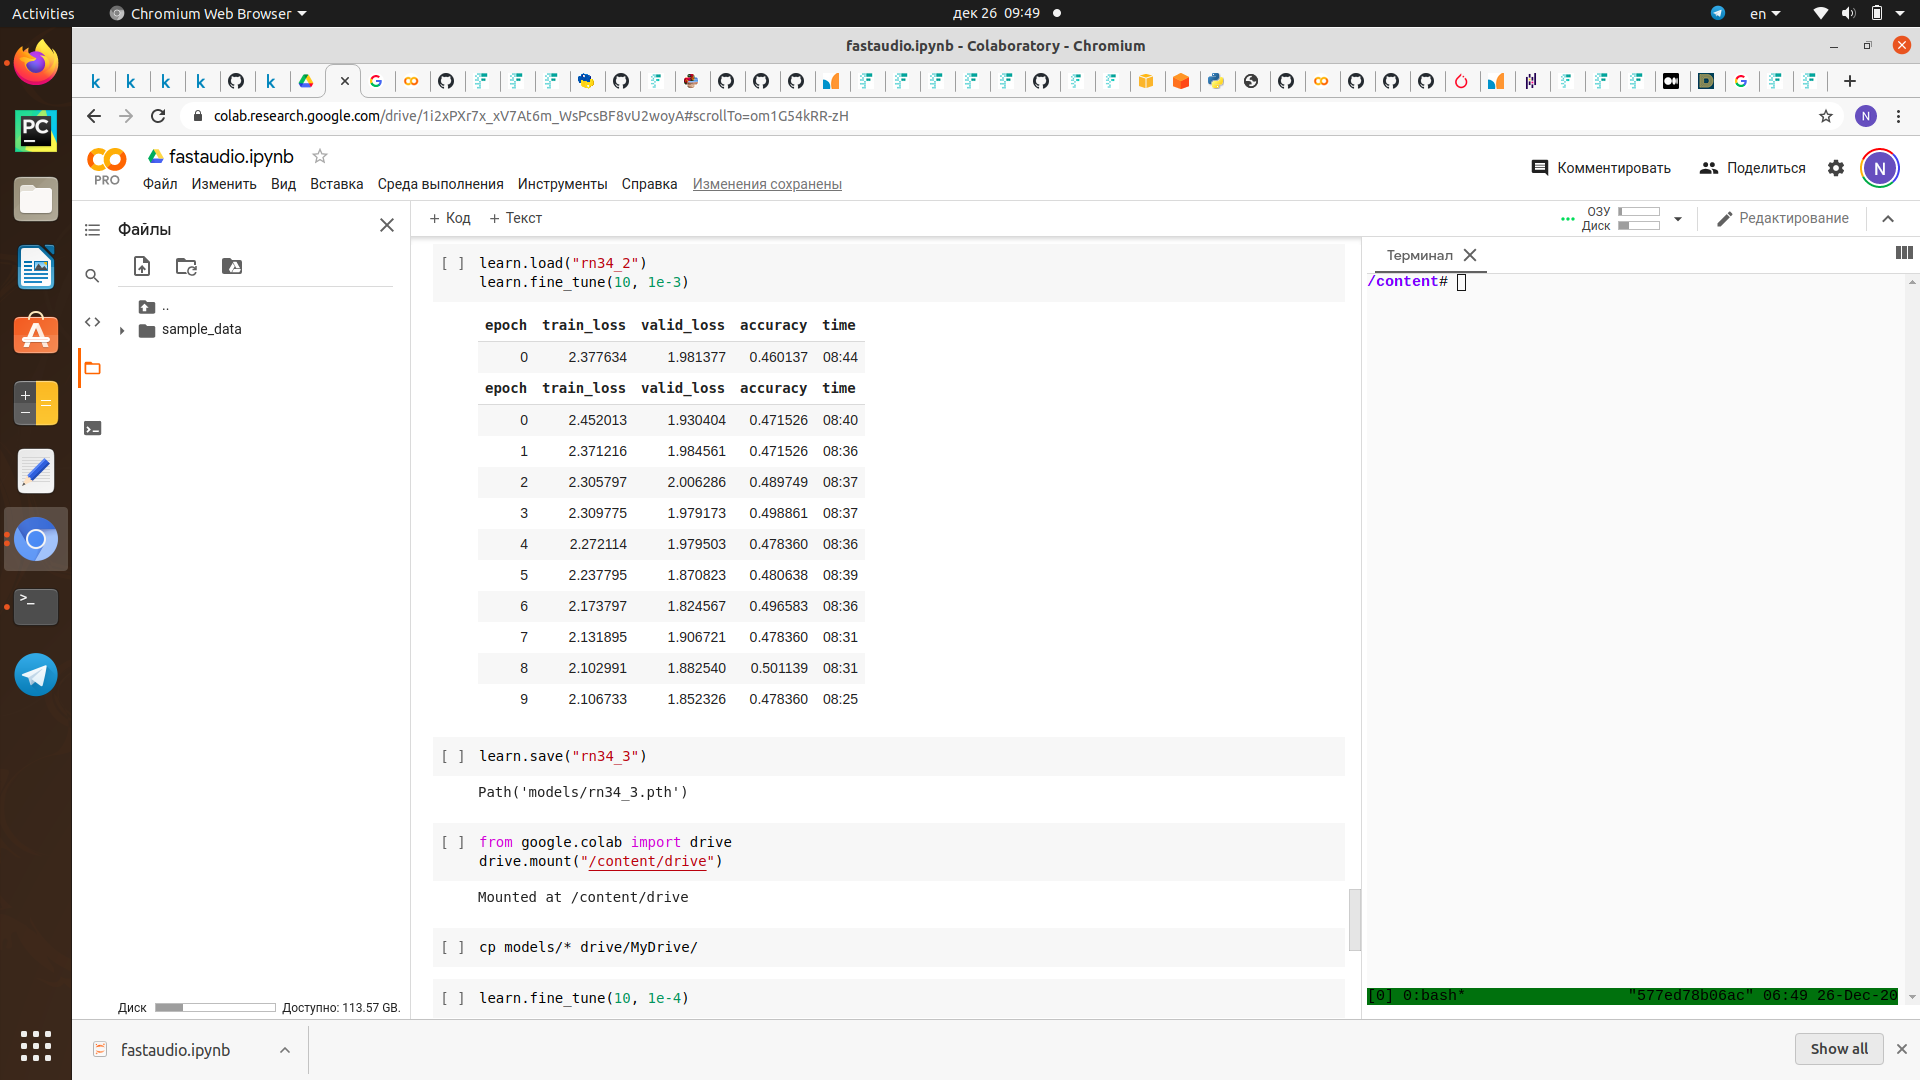

then resnet34 fit_one_cycle 20 1e-3
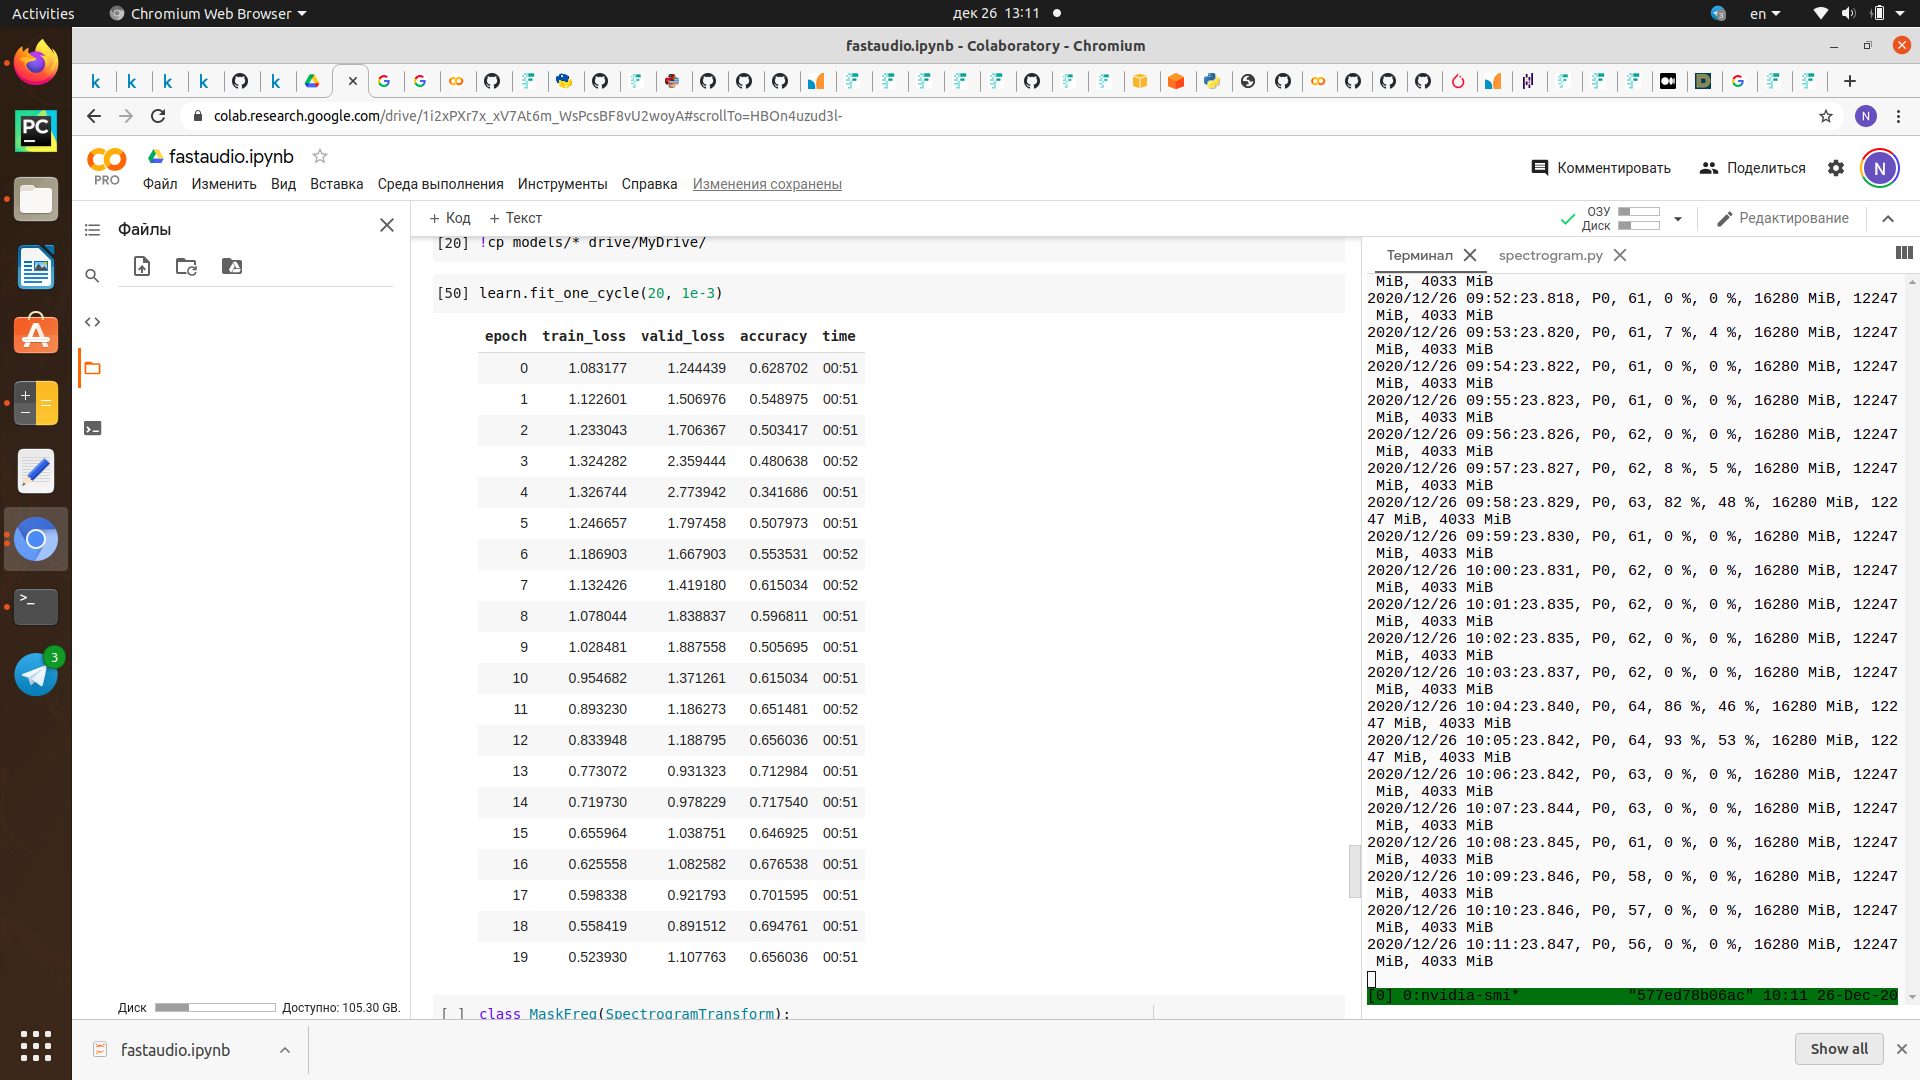